# Notebook to Visualize Huc10 Results - Prototype Model w/ New Data

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from snowML.datapipe import snow_types as st # make sure you have installed snowML package 

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Download MLFlow Metrics

In [3]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [4]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

**Approach A** Retrieve metrics frol MLFlow Tracking server

**Important Note** The three cells below are for use when running the notebook from within a Sagemaker Studio instance, with access to the Frosty Dawgs MLFlow Tracking Server for purposes of retrieving model metrics.  If that is not the case, you may instead retrieve the data from the local file names as demonstrated under step 1A.  

In [5]:
# set mlFlow tracking server 
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"

# define our run_ids by recognizable names (all from expiriment "ProtoType Results)
orig_10 = "904143d1cbfe4220afa7878fad6bd9ae" # original data, 10 epochs, MLflow name is intelligent-swan-675 
orig_30 = "0d8be0dc44a447099f7901c83032a59e"  # orig data, 30 epochs, MLflow name is legendary toad 940 
orig_200 = "41f1a7b318f94b2bb2c4fdfbf892a018"  # (orig data, 200 epochs, MLflow name is clumsy-ray-666
new_10 = "f0bde540d8184f7e8ea057456ec56f38" # new data 10 epochs, ML flow name is bittersweet-bug
new_200 = "81757efa26da4005ae1956876ea39a3b"  # new data, 200 epochs, deboniare ape 


In [6]:
df_orig30 = load_ml_metrics(tracking_uri, orig_30)
df_orig200 = load_ml_metrics(tracking_uri, orig_200)
df_orig10 = load_ml_metrics(tracking_uri, orig_10)
df_new10 = load_ml_metrics(tracking_uri, new_10)
df_new200 = load_ml_metrics(tracking_uri, new_200)


In [7]:
# save the metrics files for use offline when MLflow server not running
df_orig30.to_csv("metric_runs/Original30.csv", index=False)  
df_orig200.to_csv("metric_runs/Original200.csv", index=False)  
df_orig10.to_csv("metric_runs/Original10.csv", index=False)  
df_new10.to_csv("metric_runs/New10.csv", index=False)  
df_new200.to_csv("metric_runs/New200.csv", index=False)  

**Approach B** 
Load metrics localy from saved files. 
df_orig30 = pd.read_csv("metric_runs/Original30.csv")
df_orig200 = pd.read_csv("metric_runs/Original200.csv")  
df_orig10 = pd.read_csv("metric_runs/Original10.csv")  
df_new10 = pd.read_csv("metric_runs/New10.csv") 
df_new200 = pd.read_csv("metric_runs/New200.csv")  

In [8]:

# Now extract separate dataframes witht the test_kge and test_mse metrics, respectively 
df_orig200_tkge = extract_metric(df_orig200, "test_kge")
df_orig200_tmse = extract_metric(df_orig200, "test_mse")

 
df_orig30_tkge = extract_metric(df_orig200, "test_kge")
df_orig30_tmse = extract_metric(df_orig200, "test_mse")


df_orig10_tkge = extract_metric(df_orig10, "test_kge")
df_orig10_tmse = extract_metric(df_orig10, "test_mse")

 
df_new10_tkge = extract_metric(df_new10, "test_kge")
df_new10_tmse = extract_metric(df_new10, "test_mse")


df_new200_tkge = extract_metric(df_new200, "test_kge")
df_new200_tmse = extract_metric(df_new200, "test_mse")

In [9]:
# dispay an example
df_orig200.head()

,Metric,Step,Value
0,1711000505_train_mse,0,0.000015
1,1711000505_test_mse,0,0.011532
2,1711000505_train_kge,0,0.992485
3,1711000505_test_kge,0,0.602654
4,1711000508_train_kge,0,0.997414


# Step 2 - Define Plotting Function

In [23]:
# define a function to plot results side by side 

def plot_side_by_side(*dfs_labels, title = "Side-by-Side Metric Comparison", save_local = False):
    """Plots a side-by-side bar chart comparing values from multiple DataFrames by Metric.
    
    Parameters:
        *dfs_labels: Variable-length arguments where each pair is (df, label).
                     Example usage: plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")
    """
    
    if len(dfs_labels) % 2 != 0:
        raise ValueError("Arguments must be given as (df1, label1, df2, label2, ...).")
    
    # Process input pairs
    dfs = dfs_labels[0::2]
    labels = dfs_labels[1::2]

    # Merge all DataFrames on 'Metric'
    merged_df = dfs[0][['Metric', 'Value']].rename(columns={'Value': f'Value_{labels[0]}'})
    for df, label in zip(dfs[1:], labels[1:]):
        merged_df = merged_df.merge(df[['Metric', 'Value']], on='Metric', how='inner', suffixes=('', f'_{label}'))
        merged_df = merged_df.rename(columns={'Value': f'Value_{label}'})  # Rename to avoid conflicts

    metrics = merged_df['Metric']
    values = [merged_df[f'Value_{label}'] for label in labels]
    medians = [np.median(val) for val in values]
    
    x = np.arange(len(metrics))  # Label locations
    width = 0.8 / len(labels)  # Adjust bar width dynamically based on the number of datasets
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each dataset
    for i, (val, label, median) in enumerate(zip(values, labels, medians)):
        bars = ax.bar(x + (i - len(labels)/2) * width, val, width, label=label, alpha=0.7)
        color = bars[0].get_facecolor()  # Get the color of the bars
        # Draw a median line for each dataset
        ax.axhline(y=median, color=bars[0].get_facecolor(), linestyle='dashed', linewidth=2, alpha=0.8)
        ax.text(len(metrics) + 0.1, median, f"{label} Median: {median:.3f}", 
                va='center', ha='left', color=color, fontsize=10, fontweight='bold')
       
    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.legend()

    plt.show()
    if save_local: 
        title_r = title.replace(" ", "_")
        f_name = f"charts/{title_r}.png"
        fig.savefig(f_name, dpi=300, bbox_inches="tight")

    
# Example usage:
# plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")




# Step 3 Compare Results for varying number of Epochs, Old Data 

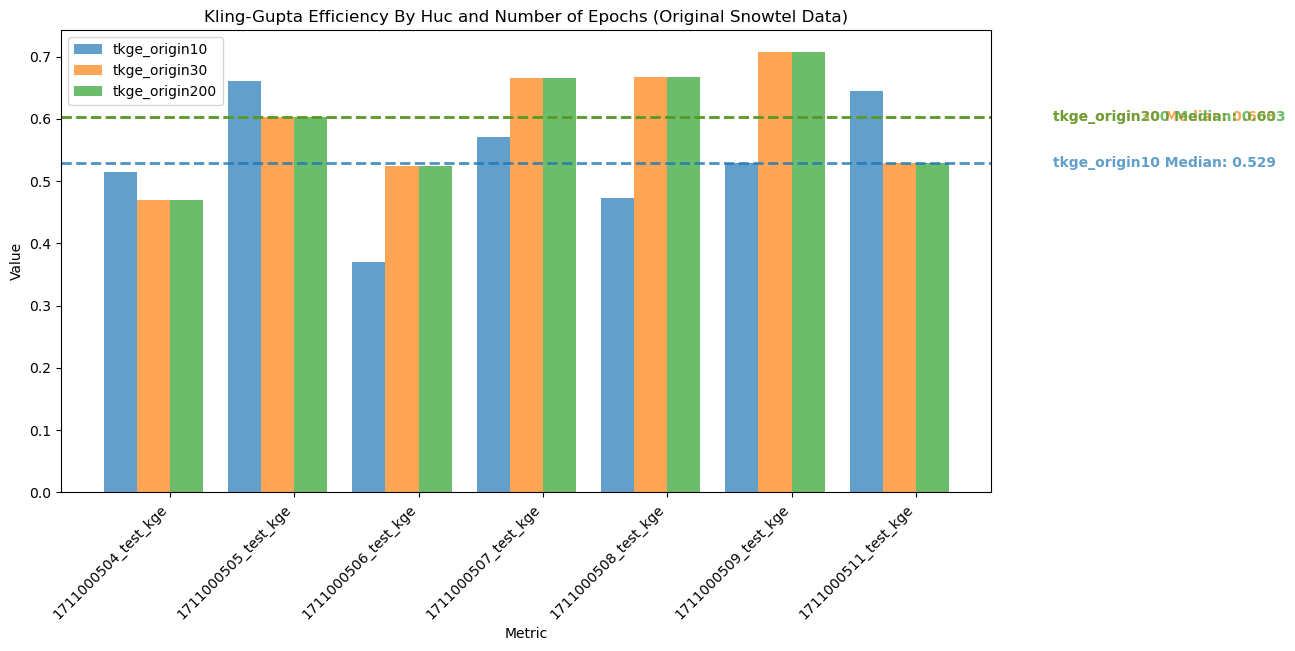

In [11]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_orig10_tkge, "tkge_origin10", 
                  df_orig30_tkge, "tkge_origin30", 
                  df_orig200_tkge, "tkge_origin200",
                  title = "Kling-Gupta Efficiency By Huc and Number of Epochs (Original Snowtel Data)")


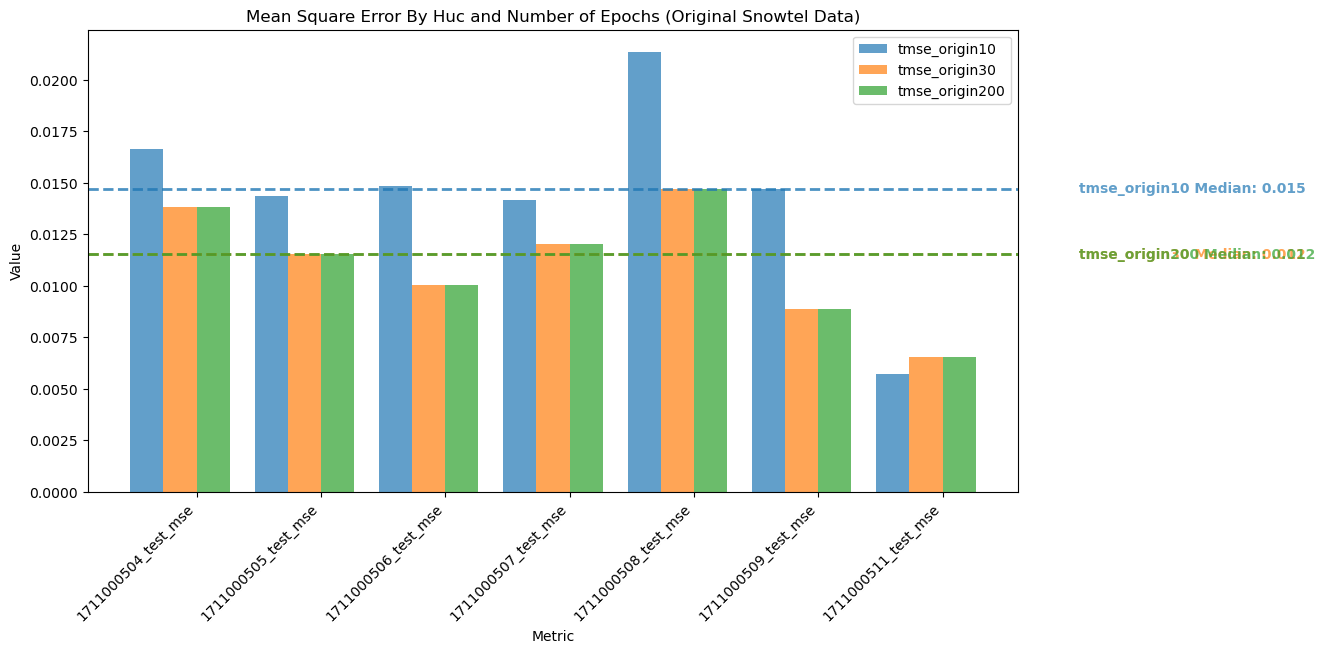

In [12]:
# MSE (Lower is better; 0 is Perfect) 
title = "Mean Square Error By Huc and Number of Epochs (Original Snowtel Data)"
plot_side_by_side(df_orig10_tmse, "tmse_origin10", df_orig30_tmse, "tmse_origin30", df_orig200_tmse, "tmse_origin200", title = title)

# Step 4 Compare Results for varying number of Epochs, New Data 

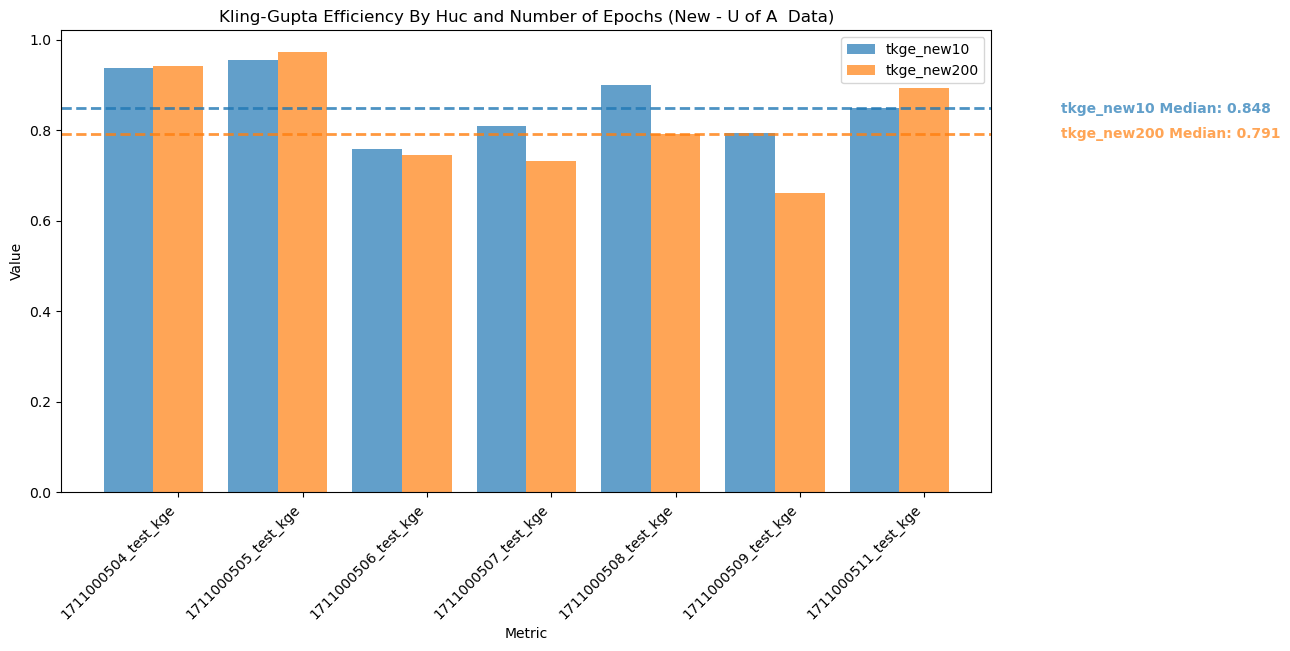

In [13]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
title = "Kling-Gupta Efficiency By Huc and Number of Epochs (New - U of A  Data)"
plot_side_by_side(df_new10_tkge, "tkge_new10", df_new200_tkge, "tkge_new200", title = title)


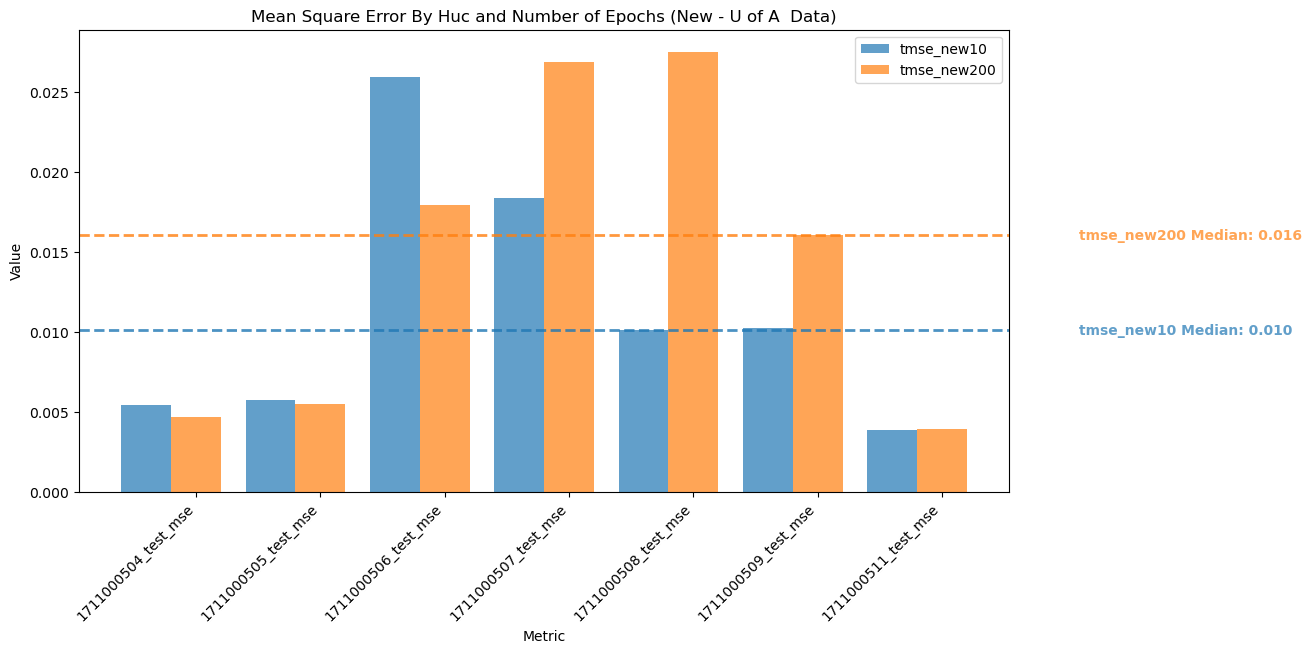

In [14]:
# MSE
title = "Mean Square Error By Huc and Number of Epochs (New - U of A  Data)"
plot_side_by_side(df_new10_tmse, "tmse_new10", df_new200_tmse, "tmse_new200", title = title)

# Step 5: Compare New Data to Old Data 

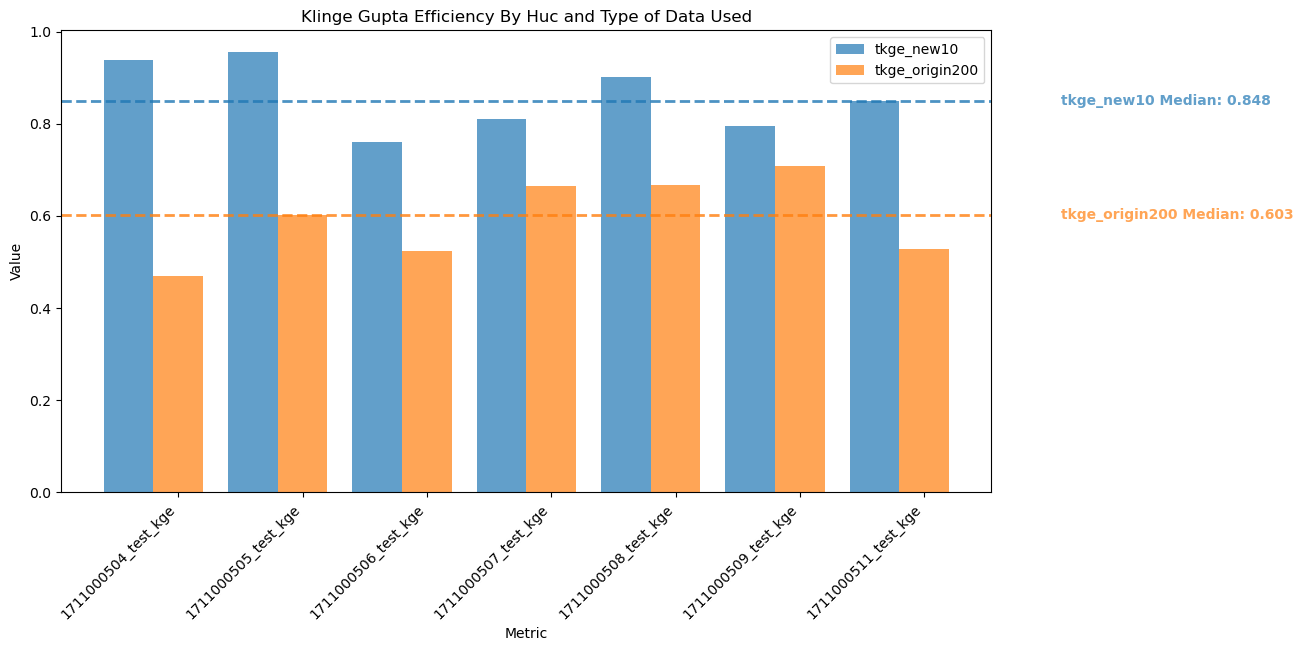

In [25]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
title = "Klinge Gupta Efficiency By Huc and Type of Data Used"
plot_side_by_side(df_new10_tkge, "tkge_new10", df_orig200_tkge, "tkge_origin200", title=title, save_local=True)


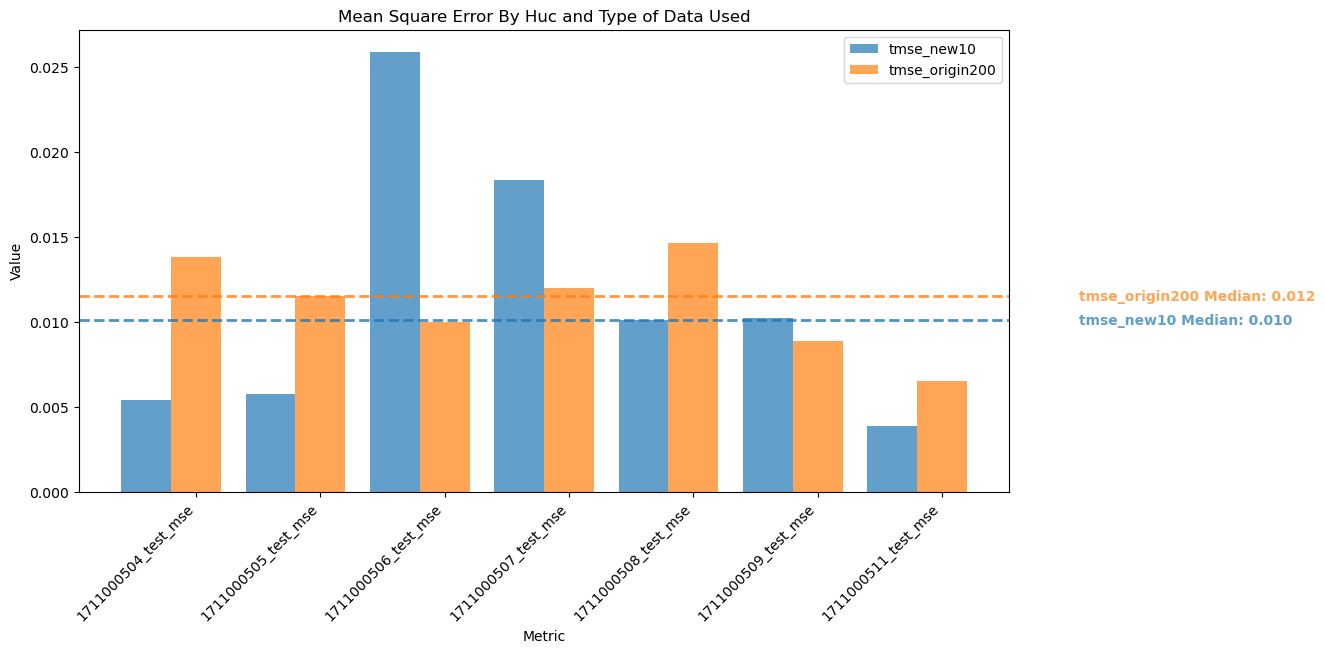

In [27]:
# MSE 
title = "Mean Square Error By Huc and Type of Data Used"
plot_side_by_side(df_new10_tmse, "tmse_new10", df_orig200_tmse, "tmse_origin200", title = title, save_local = True)


# Step 6 - Sensitivy Analysis to Epoch Selection

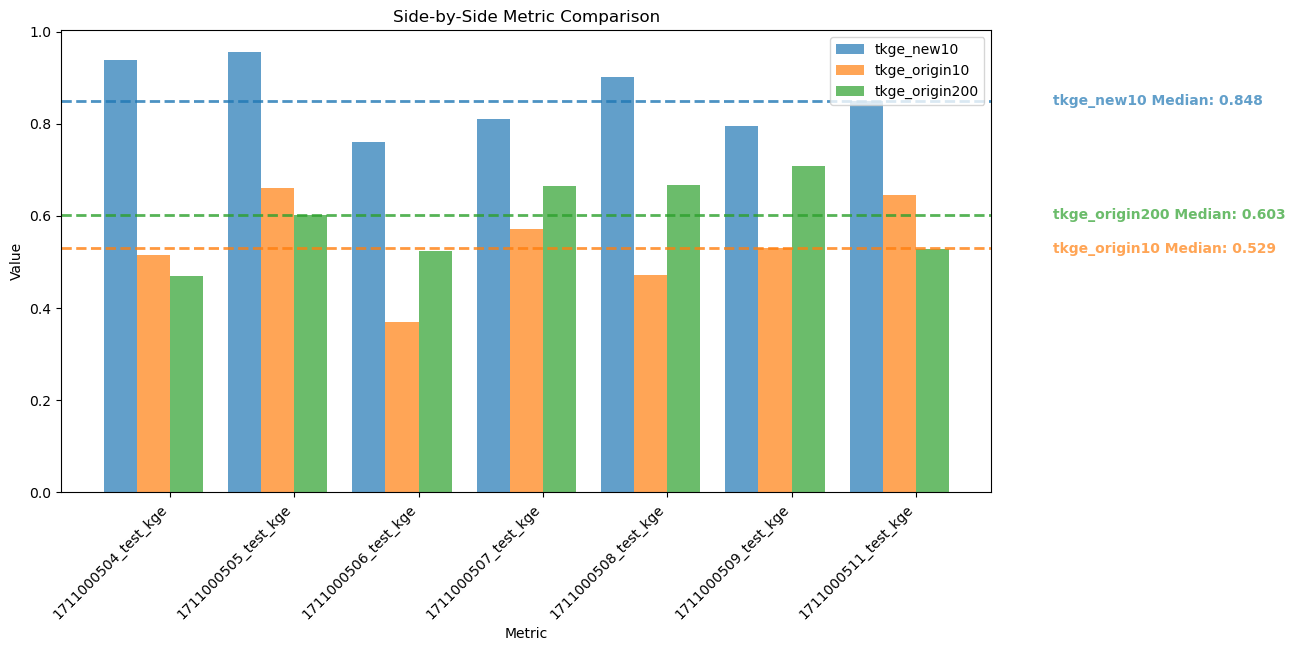

In [17]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_new10_tkge, "tkge_new10", df_orig10_tkge, "tkge_origin10", df_orig200_tkge, "tkge_origin200")

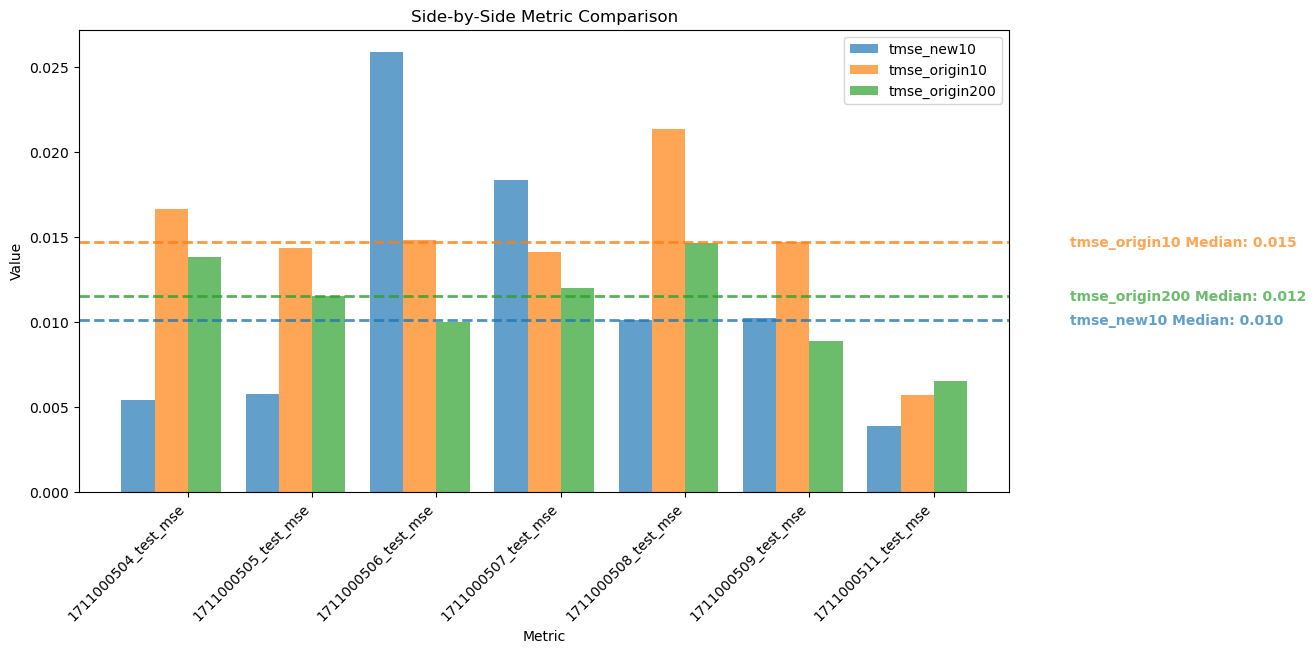

In [18]:
# MSE (Lower is better; 0 is Perfect) 
plot_side_by_side(df_new10_tmse, "tmse_new10", df_orig10_tmse, "tmse_origin10", df_orig200_tmse, "tmse_origin200")

The model using the UA Data outperforms the prior model regardless of whether prior model runs for 10 epoxh or 200. 

# Retrieve Specific Values 

In [19]:
newtkge_504 = df_new10_tkge[df_new10_tkge["Metric"] == "1711000504_test_kge"]["Value"]
print(f"Test KGE for huc 1711000504 using UA data was {newtkge_504}")


Test KGE for huc 1711000504 using UA data was 2    0.938882
Name: Value, dtype: float64


In [20]:
newmse_504 = df_new10_tmse[df_new10_tmse["Metric"] == "1711000504_test_mse"]["Value"]
print(f"Test MSE for huc 1711000504 using UA data was {newmse_504}")

Test MSE for huc 1711000504 using UA data was 7    0.005408
Name: Value, dtype: float64


In [21]:
oldmse_504 = df_orig200_tmse[df_orig200_tmse["Metric"] == "1711000504_test_mse"]["Value"]
print(f"Test MSE for huc 1711000504 using prior, Snowtel data was {oldmse_504}")

Test MSE for huc 1711000504 using prior, Snowtel data was 18    0.013807
Name: Value, dtype: float64


In [22]:
oldkge_504 = df_orig200_tkge[df_orig200_tkge["Metric"] == "1711000504_test_kge"]["Value"]
print(f"Test KGE for huc 1711000504 using prior, Snowtel data was {oldkge_504}")

Test KGE for huc 1711000504 using prior, Snowtel data was 22    0.469891
Name: Value, dtype: float64
